# Imports and preparation

In [1]:
import os

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
from tqdm import tqdm

In [5]:
import time, gc

In [6]:
import importlib

In [7]:
from itertools import product


In [8]:
from util import util_elastic

OpenAI tiktoken module is not available for Python < 3.8,Linux ARM64 and AARCH64. Falling back to GPT2TokenizerFast.


In [9]:
from util import util_pipeline

In [10]:
from util import util_experiment

In [11]:
# Para ter repetibilidade nos resultados
random_state = 1

# Tratar valores infinitos (+ e -) como np.NaN
pd.options.mode.use_inf_as_na = True

# IMPORTANTE para tornar figuras interativas
# %matplotlib notebook

# Tamanho padrão das figuras
figsize=(10,6)

pd.set_option('display.max_row', 1000)

pd.set_option('display.max_columns', 50)

pd.set_option('display.column_space', 40)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 200)


In [12]:
PATH_QUERY = '../data/juris_tcu_index/query.csv'
PATH_QREL =  '../data/juris_tcu_index/qrel.csv'

# Data load

## Query data load

In [13]:
df_query = pd.read_csv(PATH_QUERY)

In [14]:
df_query.shape

(16045, 11)

In [15]:
df_query[df_query['ID']==2845]

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
5618,2845,"Em regra, o pregão é a modalidade de licitação adequada para a concessão remunerada de uso de be...",NaN,NaN,Licitação,932,REPRESENTAÇÃO,Acórdão 478/2016 - Plenário,2016-03-02,RELATOR,MARCOS BEMQUERER


In [16]:
df_query.head()

,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME
0,13568,"É ilegal a contagem de tempo ficto de serviço prestado sob a égide da Lei 3.313/1957, proporcion...",Lei Complementar 51/1985 || Lei Ordinária 3313/1957,NaN,Pessoal,1131,APOSENTADORIA,Acórdão 168/2014 - Segunda Câmara,2014-01-28,RELATOR,JOSÉ JORGE
1,11614,"SÚMULA TCU 283: Para fim de habilitação, a Administração Pública não deve exigir dos licitantes ...",NaN,SUMULA,Licitação,932,ADMINISTRATIVO,Acórdão 1613/2013 - Plenário,2013-06-26,RELATOR,JOSÉ JORGE
2,21087,"A contratação de serviços por preços superiores às referências legais (Sinapi e Sicro) deve ser,...",NaN,NaN,Licitação,932,PRESTAÇÃO DE CONTAS,Acórdão 3936/2013 - Segunda Câmara,2013-07-09,RELATOR,ANA ARRAES
3,35016,"Não se aplica, excepcionalmente, multa aos gestores por grave infração à norma legal se a irregu...",NaN,NaN,Responsabilidade,775,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ
4,29370,"Em contratatações de TI, não cabe aceitar propostas de preço com incidência de encargos majorado...",NaN,NaN,Licitação,932,REPRESENTAÇÃO,Acórdão 3231/2011 - Plenário,2011-12-07,RELATOR,AROLDO CEDRAZ


## Qrel data load

In [17]:
df_qrel = pd.read_csv(PATH_QREL)

In [18]:
df_qrel.shape

(94809, 3)

In [19]:
df_qrel.head()

,ID_QUERY,ID_DOCTO,TYPE
0,158,15147,INDEXACAO_EXTRA
1,37,15147,INDEXACAO_EXTRA
2,178,15147,INDEXACAO_EXTRA
3,14564,15147,INDEXACAO_EXTRA
4,9219,15147,INDEXACAO_EXTRA


In [20]:
df_qrel.shape[0]

94809

In [21]:
df_search_data = df_query.merge(df_qrel, how='left', left_on='ID', right_on='ID_QUERY').drop('ID_QUERY', axis=1)

In [22]:
df_search_data.shape[0]


94809

In [23]:
# Agrupar os dados pelo ID e criar a coluna 'RELEVANCE_LIST' com a lista de tuplas
# df_new = df_search_data.groupby('ID').apply(lambda x: list(zip(x['ID_DOCTO'], x['TYPE']))).reset_index(name='RELEVANCE_LIST')
# df_new['RELEVANCE_LIST'] = df_new['RELEVANCE_LIST'].apply(lambda x: sorted(x, key=lambda tup: ('AREA', 'TEMA', 'SUBTEMA', 'INDEXACAO_EXTRA').index(tup[1])))
df_new = df_search_data.groupby('ID').apply(lambda x: dict(zip(x['ID_DOCTO'], x['TYPE']))).reset_index(name='RELEVANCE_DICT')


In [24]:
df_new.head()

,ID,RELEVANCE_DICT
0,5,"{1298: 'INDEXACAO_EXTRA', 15340: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106..."
1,6,"{207: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106: 'SUBTEMA', 1113: 'TEMA'}"
2,7,"{108: 'INDEXACAO_EXTRA', 1526: 'TEMA', 1727: 'SUBTEMA', 223: 'INDEXACAO_EXTRA', 650: 'INDEXACAO_..."
3,8,"{887: 'SUBTEMA', 92: 'TEMA', 1131: 'AREA', 1100820: 'INDEXACAO_EXTRA'}"
4,9,"{1215: 'INDEXACAO_EXTRA', 14715: 'SUBTEMA', 46: 'TEMA', 1480: 'INDEXACAO_EXTRA', 5095: 'AREA'}"


In [25]:
# Unir o resultado com as demais colunas únicas
df_new = pd.merge(df_new, df_search_data.drop_duplicates('ID'), on='ID', how='left')

In [26]:

# Selecionar as colunas desejadas
df_search_data = df_new[['ID', 'TEXT', 'REFERENCE_LIST', 'PARADIGMATIC', 'AREA_NAME', 'AREA_ID_DESCRIPTOR', 'NORMATIVE_PROCESS_TYPE', 'NORMATIVE_IDENTIFICATION', 'NORMATIVE_DATE', 'NORMATIVE_AUTHOR_TYPE', 'NORMATIVE_AUTHOR_NAME', 'RELEVANCE_DICT']]


In [27]:
df_search_data.shape

(16045, 12)

In [28]:
df_search_data = df_search_data.reset_index()

In [29]:
df_search_data.head()

,index,ID,TEXT,REFERENCE_LIST,PARADIGMATIC,AREA_NAME,AREA_ID_DESCRIPTOR,NORMATIVE_PROCESS_TYPE,NORMATIVE_IDENTIFICATION,NORMATIVE_DATE,NORMATIVE_AUTHOR_TYPE,NORMATIVE_AUTHOR_NAME,RELEVANCE_DICT
0,0,5,"SÚMULA TCU 1: Não se compreendem como vencimento, para efeito de concessão da pensão especial co...","Lei Ordinária 3738/1960 || Lei Ordinária 1711/1952, art. 184",SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{1298: 'INDEXACAO_EXTRA', 15340: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106..."
1,1,6,"SÚMULA TCU 2: Configura-se como vencimento, para efeito da concessão da pensão especial com fund...",Lei Ordinária 3738/1960,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{207: 'INDEXACAO_EXTRA', 15961: 'INDEXACAO_EXTRA', 1131: 'AREA', 5106: 'SUBTEMA', 1113: 'TEMA'}"
2,2,7,SÚMULA TCU 3: O arquivamento é a solução indicada para as hipóteses em que as contas de responsá...,NaN,SUMULA,Direito processual,5288,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{108: 'INDEXACAO_EXTRA', 1526: 'TEMA', 1727: 'SUBTEMA', 223: 'INDEXACAO_EXTRA', 650: 'INDEXACAO_..."
3,3,8,"SÚMULA TCU 4: A reclassificação de cargos não aproveita ao servidor aposentado, a menos que lei ...",NaN,SUMULA,Pessoal,1131,NaN,Ata 88/1973 - Plenário,1973-12-04,RELATOR,OCTÁVIO GALLOTTI,"{887: 'SUBTEMA', 92: 'TEMA', 1131: 'AREA', 1100820: 'INDEXACAO_EXTRA'}"
4,4,9,"SÚMULA TCU 5 (REVOGADA): As sociedades de economia mista, salvo disposição expressa em lei, não ...",NaN,SUMULA,Competência do TCU,5095,NaN,AC 2082/2007-PL,2007-10-03,RELATOR,UBIRATAN AGUIAR,"{1215: 'INDEXACAO_EXTRA', 14715: 'SUBTEMA', 46: 'TEMA', 1480: 'INDEXACAO_EXTRA', 5095: 'AREA'}"


In [30]:
del df_new

# Create reference to index (elastic search)

Documentation https://docs.haystack.deepset.ai/docs
https://haystack.deepset.ai/tutorials/09_dpr_training 


In [31]:
index_dict = util_elastic.return_indexes('indir', parm_print=True)

Index: indir_juris_tcu
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu', 'uuid': 'RD_aAWppQH6vjNxKUdL_0w', 'pri': '1', 'rep': '1', 'docs.count': '16045', 'docs.deleted': '16045', 'store.size': '334.9mb', 'pri.store.size': '334.9mb'}

Index: indir_juris_tcu_index
{'health': 'yellow', 'status': 'open', 'index': 'indir_juris_tcu_index', 'uuid': 'fGjzBrQzRUWTZ6KlnbfLqw', 'pri': '1', 'rep': '1', 'docs.count': '13255', 'docs.deleted': '2755', 'store.size': '281.7mb', 'pri.store.size': '281.7mb'}



In [32]:
index_dict

{'indir_juris_tcu': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu',
  'uuid': 'RD_aAWppQH6vjNxKUdL_0w',
  'pri': '1',
  'rep': '1',
  'docs.count': '16045',
  'docs.deleted': '16045',
  'store.size': '334.9mb',
  'pri.store.size': '334.9mb'},
 'indir_juris_tcu_index': {'health': 'yellow',
  'status': 'open',
  'index': 'indir_juris_tcu_index',
  'uuid': 'fGjzBrQzRUWTZ6KlnbfLqw',
  'pri': '1',
  'rep': '1',
  'docs.count': '13255',
  'docs.deleted': '2755',
  'store.size': '281.7mb',
  'pri.store.size': '281.7mb'}}

In [33]:
INDEX_NAME = 'indir_juris_tcu_index'

In [34]:
index = util_elastic.return_index(parm_index_name=INDEX_NAME)


Qtd de documentos 13255

Qtd de embeddings 13255

Documento.id=5: <Document: id=5, content='O termo é "Abono de permanência em serviço".
Abono de permanência em serviço tem definição: "O abono...'>


# Pipelines creation

In [35]:
pipes = []

In [36]:
# Test query
# parm_query = "trata-se de uma denúncia contra o prefeito de Manhuaçu por não haver pago os funcionários da área de limpeza urbana"
parm_query = "A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou."

In [37]:
raise Exception ('Stop execution - create only desired pipelines in code below ')

Exception: Stop execution - create only desired pipelines in code below 

## Only retrievers

### join

#### sts + bm25

In [ ]:
%%time
pipe_join_sts_bm25 = util_pipeline.return_pipeline_join_bm25_sts(index)

CPU times: user 3.52 s, sys: 778 ms, total: 4.3 s
Wall time: 2.66 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_join_sts_bm25',
              'PIPE_OBJECT': pipe_join_sts_bm25,
              'RETRIEVER_TYPE': 'join_sts_bm25',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_join_sts_bm25.run(query=parm_query, 
 params={"Bm25Retriever": {"top_k": 300}, "StsRetriever": {"top_k": 300}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Bm25Retriever': {'top_k': 300}, 'StsRetriever': {'top_k': 300}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 542
Primeiro docto:
<Document: id=1102005, content='O termo é "Plano de contratações".
Plano de contratações tem definição: "É o documento no qual a org...'>

Último (542):
<Document: id=1103641, content='O termo é "Falta grave".
Falta grave tem nota de escopo: "Está prevista em várias normatizações que ...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Plano de contratações', '1102005', 0.981894035831847]
1 : ['Competência do TCU', '5095', 0.981022770821533]
2 : ['Nexo de causalidade', '4495', 0.9782476752974565]
3 : ['Teletrabalho', '5949', 0.977450618284214]
4 : ['Papéis de trabalho', '15181', 0.976140477988525]
5

#### sts_multihop + bm25

In [ ]:
%%time
pipe_join_sts_multihop_bm25 = util_pipeline.return_pipeline_join_bm25_sts_multihop(index)

CPU times: user 3.36 s, sys: 674 ms, total: 4.04 s
Wall time: 2.12 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_join_sts_multihop_bm25',
              'PIPE_OBJECT': pipe_join_sts_multihop_bm25,
              'RETRIEVER_TYPE': 'join_sts_multihop_bm25',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_join_sts_multihop_bm25.run(query=parm_query, 
 params={"Bm25Retriever": {"top_k": 150}, "StsRetriever": {"top_k": 150}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Bm25Retriever': {'top_k': 150}, 'StsRetriever': {'top_k': 150}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 289
Primeiro docto:
<Document: id=2577, content='O termo é "Afastamento de responsável".
Afastamento de responsável tem definição: "No início ou no c...'>

Último (289):
<Document: id=1102397, content='O termo é "Estado de exceção".
Estado de exceção tem nota de escopo: "Situação oposta ao Estado demo...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Afastamento de responsável', 0.9930839884285582]
1 : ['Plano de contratações', 0.9856940203493179]
2 : ['Competência do TCU', 0.9849874794705751]
3 : ['Teletrabalho', 0.9823437136689326]
4 : ['Nexo de causalidade', 0.982157658932855]
5 : ['Processo administrativo de resp

### sts_multihop

In [ ]:
%%time
pipe_sts_multihop = util_pipeline.return_pipeline_sts_multihop(index)

CPU times: user 3.39 s, sys: 715 ms, total: 4.11 s
Wall time: 2.16 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_sts_multihop',
              'PIPE_OBJECT': pipe_sts_multihop,
              'RETRIEVER_TYPE': 'sts_multihop',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_sts_multihop.run(query=parm_query, 
 params={"Retriever": {"top_k": 300}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Retriever': {'top_k': 300}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 300
Primeiro docto:
<Document: id=2577, content='O termo é "Afastamento de responsável".
Afastamento de responsável tem definição: "No início ou no c...'>

Último (300):
<Document: id=2550, content='O termo é "Declaração de nulidade".
Declaração de nulidade tem definição: "Declaração que torna o co...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Afastamento de responsável', 0.9930839884285582]
1 : ['Rescisão unilateral', 0.9748706914060489]
2 : ['Afastamento preventivo', 0.9741557736812957]
3 : ['Perda de objeto', 0.9725962719359168]
4 : ['Abandono de cargo', 0.9696305808093489]
5 : ['Responsabilidade perante o controle externo', 0.9692663708644913]


### sts

In [ ]:
%%time
pipe_sts = util_pipeline.return_pipeline_sts(index)

CPU times: user 3.09 s, sys: 638 ms, total: 3.72 s
Wall time: 2.12 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_sts',
              'PIPE_OBJECT': pipe_sts,
              'RETRIEVER_TYPE': 'sts',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [ ]:
%%time
doctos_retornados_ranker = pipe_sts.run(query=parm_query, 
 params={"Retriever": {"top_k": 300}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Retriever': {'top_k': 300}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 300
Primeiro docto:
<Document: id=2577, content='O termo é "Afastamento de responsável".
Afastamento de responsável tem definição: "No início ou no c...'>

Último (300):
<Document: id=1103641, content='O termo é "Falta grave".
Falta grave tem nota de escopo: "Está prevista em várias normatizações que ...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Afastamento de responsável', 0.9546168861748239]
1 : ['Risco de controle', 0.943127201770828]
2 : ['Vazamento de dados', 0.942404112002669]
3 : ['Trancamento das contas', 0.9341491636096659]
4 : ['Revisão de ofício', 0.9297291992714615]
5 : ['Responsabilidade perante o controle externo', 0.9294792178601551

### bm25

In [38]:
%%time
pipe_bm25 = util_pipeline.return_pipeline_bm25(index)

CPU times: user 616 µs, sys: 47 µs, total: 663 µs
Wall time: 662 µs


In [39]:
pipes.append({'PIPE_NAME': 'pipe_bm25',
              'PIPE_OBJECT': pipe_bm25,
              'RETRIEVER_TYPE': 'bm25', 
              'RETRIEVER_MODEL_NAME': '', # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': ''})

In [40]:
%%time
doctos_retornados_ranker = pipe_bm25.run(query=parm_query, 
 params={"Retriever": {"top_k": 300}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Retriever': {'top_k': 300}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 300
Primeiro docto:
<Document: id=1102005, content='O termo é "Plano de contratações".
Plano de contratações tem definição: "É o documento no qual a org...'>

Último (300):
<Document: id=6150, content='O termo é "Gestão de risco".
Gestão de risco tem definição: "Identificar, analisar e eliminar, se po...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Plano de contratações', '1102005', 0.981894035831847]
1 : ['Competência do TCU', '5095', 0.981022770821533]
2 : ['Nexo de causalidade', '4495', 0.9782476752974565]
3 : ['Teletrabalho', '5949', 0.977450618284214]
4 : ['Evidência documental', '1101364', 0.9766837588293696]
5 : ['Processo administrativo de re

## With rankers

In [ ]:
importlib.reload(util_pipeline)

### First stage = sts_multihop

In [ ]:
importlib.reload(util_experiment)

<module 'util.util_search' from '/home/borela/fontes/ind-ir/code/util/util_search.py'>

In [ ]:
%%time
pipe_sts_multihop_ranker_monot5_3b = util_pipeline.return_pipeline_sts_multihop_reranker(index, 'MONOT5', parm_limit_query_size=350)

CPU times: user 39.1 s, sys: 7.6 s, total: 46.7 s
Wall time: 36.4 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_sts_multihop_ranker_monot5_3b',
              'PIPE_OBJECT': pipe_sts_multihop_ranker_monot5_3b,
              'RETRIEVER_TYPE': 'sts_multihop',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': util_pipeline.nome_modelo_monot5_3b})

In [ ]:
%%time
doctos_retornados_ranker = pipe_sts_multihop_ranker_monot5_3b.run(query=parm_query, params= {'Retriever': {'filters':{'class':['Termo']}}}) 
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Retriever': {'filters': {'class': ['Termo']}}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 10
Primeiro docto:
<Document: id=5098, content='O termo é "Responsabilidade perante o controle externo".
Responsabilidade perante o controle externo...'>

Último (10):
<Document: id=5450, content='O termo é "Dispensa sem justa causa".
Dispensa sem justa causa tem definição: "Art. 477.  Na extinçã...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Responsabilidade perante o controle externo', -0.29318735003471375]
1 : ['Afastamento de responsável', -0.8160551190376282]
2 : ['Descarte de documentos', -1.4474653005599976]
3 : ['Excludente de responsabilidade', -2.6080782413482666]
4 : ['Perda de objeto', -2.8628034591674805]
5 : ['Afasta

### First stage = Join

#### bm25 + sts

In [ ]:
import importlib
importlib.reload(util_experiment)

<module 'util.util_experiment' from '/home/borela/fontes/ind-ir/code/util/util_experiment.py'>

In [ ]:
%%time
pipe_join_ranker_monot5_3b = util_pipeline.return_pipeline_join_bm25_sts_reranker(index, 'MONOT5', parm_limit_query_size=350)

CPU times: user 37.6 s, sys: 11.3 s, total: 48.9 s
Wall time: 1min 22s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_join_ranker_monot5_3b',
              'PIPE_OBJECT': pipe_join_ranker_monot5_3b,
              'RETRIEVER_TYPE': 'join_sts_bm25',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': util_pipeline.nome_modelo_monot5_3b})

In [ ]:
%%time
doctos_retornados_ranker = pipe_join_ranker_monot5_3b.run(query=parm_query, 
 params={"Bm25Retriever": {"top_k": 300}, "StsRetriever": {"top_k": 300}, "Ranker": {"top_k": 10}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Bm25Retriever': {'top_k': 300}, 'StsRetriever': {'top_k': 300}, 'Ranker': {'top_k': 10}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 10
Primeiro docto:
<Document: id=5098, content='O termo é "Responsabilidade perante o controle externo".
Responsabilidade perante o controle externo...'>

Último (10):
<Document: id=1525, content='O termo é "Tomada de contas". Tomada de contas tem definição: "Levantamento organizado por serviço d...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Responsabilidade perante o controle externo', '5098', -0.29322895407676697]
1 : ['Achado de auditoria', '2700', -0.5342227220535278]
2 : ['Termo de sigilo', '1000057', -0.6638156771659851]
3 : ['Encaminhamento das contas', '1739', -0.7583333253860474]

#### bm25 + sts_multihop

In [ ]:
import importlib
importlib.reload(util_pipeline)

<module 'util.util_pipeline' from '/home/borela/fontes/ind-ir/code/util/util_pipeline.py'>

In [ ]:
%%time
pipe_join_multihop_ranker_monot5_3b = util_pipeline.return_pipeline_join_bm25_sts_multihop_reranker(index, 'MONOT5', parm_limit_query_size=350)

CPU times: user 39.4 s, sys: 7.46 s, total: 46.9 s
Wall time: 36.4 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_join_multihop_ranker_monot5_3b',
              'PIPE_OBJECT': pipe_join_multihop_ranker_monot5_3b,
              'RETRIEVER_TYPE': 'join_sts_multihop_bm25',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': util_pipeline.nome_modelo_monot5_3b})

In [ ]:
%%time
doctos_retornados_ranker = pipe_join_multihop_ranker_monot5_3b.run(query=parm_query, 
 params={"Bm25Retriever": {"top_k": 150}, "StsRetriever": {"top_k": 150}, "Ranker": {"top_k": 10}})
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {'Bm25Retriever': {'top_k': 150}, 'StsRetriever': {'top_k': 150}, 'Ranker': {'top_k': 10}}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 10
Primeiro docto:
<Document: id=5098, content='O termo é "Responsabilidade perante o controle externo".
Responsabilidade perante o controle externo...'>

Último (10):
<Document: id=6130, content='O termo é "Informação reservada". Informação reservada tem definição: "Informação imprescindível à s...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Responsabilidade perante o controle externo', -0.29319456219673157]
1 : ['Termo de sigilo', -0.663377583026886]
2 : ['Afastamento de responsável', -0.8160808086395264]
3 : ['Revisão de ofício', -0.9920899271965027]
4 : ['Processo administrativo de res

### First stage = BM25

#### pipe_bm25_ranker_monot5_3b

In [ ]:
%%time
pipe_bm25_ranker_monot5_3b = util_pipeline.return_pipeline_bm25_reranker(index, 'MONOT5', parm_limit_query_size=350)

CPU times: user 35.2 s, sys: 8.64 s, total: 43.8 s
Wall time: 36.7 s


In [ ]:
pipes.append({'PIPE_NAME': 'pipe_bm25_ranker_monot5_3b',
              'PIPE_OBJECT': pipe_bm25_ranker_monot5_3b,
              'RETRIEVER_TYPE': 'bm25',  # or 'sts'
              'RETRIEVER_MODEL_NAME': '', # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': util_pipeline.nome_modelo_monot5_3b})

In [ ]:
doctos_retornados_ranker = pipe_bm25_ranker_monot5_3b.run(query=parm_query)
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 10
Primeiro docto:
<Document: id=1104189, content='O termo é "Processo administrativo de responsabilização". Processo administrativo de responsabilizaç...'>

Último (10):
<Document: id=1102005, content='O termo é "Plano de contratações".
Plano de contratações tem definição: "É o documento no qual a org...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Processo administrativo de responsabilização', -1.0603076219558716]
1 : ['Competência do TCU', -1.4214444160461426]
2 : ['Evidência documental', -1.9571717977523804]
3 : ['Ofício de requisição', -2.266594648361206]
4 : ['Julgamento de contas', -2.5948143005371094]
5 : ['Nexo de causalidade', -3.0983963012695312]
6 : ['Teletrabalho'

#### pipe_bm25_ranker_minilm

In [ ]:
pipe_bm25_ranker_minilm = util_pipeline.return_pipeline_bm25_reranker(index, 'MINILM', parm_limit_query_size=350)

In [ ]:
pipes.append({'PIPE_NAME': 'pipe_bm25_ranker_minilm',
              'PIPE_OBJECT': pipe_bm25_ranker_minilm,
              'RETRIEVER_TYPE': 'bm25',  # or 'sts'
              'RETRIEVER_MODEL_NAME': '', # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': util_pipeline.nome_modelo_ranking_minilm})

In [ ]:
doctos_retornados_ranker = pipe_bm25_ranker_minilm.run(query=parm_query)
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 10
Primeiro docto:
<Document: id=5095, content='O termo é "Competência do TCU". Competência do TCU tem definição: "São as seguintes as competências ...'>

Último (10):
<Document: id=4495, content='O termo é "Nexo de causalidade".
Nexo de causalidade tem definição: "Elemento que evidencia se a con...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Competência do TCU', 0.0014646538766101003]
1 : ['Processo administrativo de responsabilização', 0.0004114470211789012]
2 : ['Evidência documental', 0.00033812460605986416]
3 : ['Plano de contratações', 0.0002457168884575367]
4 : ['Julgamento de contas', 0.00022130725847091526]
5 : ['Teletrabalho', 0.00016929447883740067]
6 : ['Ofício de

### First stage = Sentence Similarity

#### pipe_sts_ranker_minilm

In [ ]:
pipe_sts_ranker_minilm = util_pipeline.return_pipeline_sts_reranker(index, 'MINILM', parm_limit_query_size=350)

NameError: name 'parm_path_model_ranker' is not defined

In [ ]:
pipes.append({'PIPE_NAME': 'pipe_sts_ranker_minilm',
              'PIPE_OBJECT': pipe_sts_ranker_minilm,
              'RETRIEVER_TYPE': 'sts',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': util_pipeline.nome_modelo_ranking_minilm})

In [ ]:
doctos_retornados_ranker = pipe_sts_ranker_minilm.run(query=parm_query)
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 10
Primeiro docto:
<Document: id=1110487, content='O termo é "Vazamento de dados".
Vazamento de dados tem definição: "Transmissão não-autorizada de dad...'>

Último (10):
<Document: id=15939, content='O termo é "Erro de procedimento".
Erro de procedimento tem definição: "É um vício de forma, extrínse...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Vazamento de dados', 0.0024509401991963387]
1 : ['Termo de sigilo', 0.0007997120846994221]
2 : ['Trancamento das contas', 0.0002845456183422357]
3 : ['Risco de controle', 0.00022979704954195768]
4 : ['Revisão de ofício', 0.00013715452223550528]
5 : ['Responsabilidade perante o controle externo', 0.00013104191748425364]
6 : ['Anulação

#### pipe_sts_ranker_monot5_3b

In [ ]:
pipe_sts_ranker_monot5_3b = util_pipeline.return_pipeline_sts_reranker(index, 'MONOT5', parm_limit_query_size=350)

In [ ]:
pipes.append({'PIPE_NAME': 'pipe_sts_ranker_monot5_3b',
              'PIPE_OBJECT': pipe_sts_ranker_monot5_3b,
              'RETRIEVER_TYPE': 'sts',  # in ['sts', 'bm25']
              'RETRIEVER_MODEL_NAME': util_pipeline.nome_modelo_embedding_model_sts, # or nome_modelo_embedding_model_sts_rufimelo,
              'RANKER_MODEL_NAME': util_pipeline.nome_modelo_monot5_3b})

In [ ]:
doctos_retornados_ranker = pipe_sts_ranker_monot5_3b.run(query=parm_query)
util_pipeline.detail_document_found(doctos_retornados_ranker)

Parâmetros usados: {}
Consulta: A transferência de documentos da entidade para local impróprio ao armazenamento, causando a perda de informações ou inviabilizando seu manuseio, de forma a impedir a atuação do TCU, é causa de responsabilização do gestor que a ordenou.
Qtd documentos retornados: 10
Primeiro docto:
<Document: id=5098, content='O termo é "Responsabilidade perante o controle externo".
Responsabilidade perante o controle externo...'>

Último (10):
<Document: id=83, content='O termo é "Anulação". Anulação tem definição: "É o ato ou a decisão, de caráter judicial ou administ...'>
Seguem os nomes dos termos recuperados em ordem de score
0 : ['Responsabilidade perante o controle externo', -0.29301929473876953]
1 : ['Termo de sigilo', -0.6637465357780457]
2 : ['Afastamento de responsável', -0.8156272172927856]
3 : ['Revisão de ofício', -0.9923231601715088]
4 : ['Trancamento das contas', -1.1499707698822021]
5 : ['Erro de procedimento', -2.8979315757751465]
6 : ['Vazamento de dado

## Impressão de pipe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


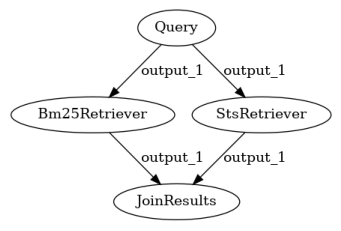

In [ ]:
util_pipeline.imprime_pipe(pipe_join_sts_multihop_bm25)

# Experiments

In [41]:
pipes

[{'PIPE_NAME': 'pipe_bm25',
  'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline at 0x7f1d07d64410>,
  'RETRIEVER_TYPE': 'bm25',
  'RETRIEVER_MODEL_NAME': '',
  'RANKER_MODEL_NAME': ''}]

In [46]:
grid_experiment = {'CRITERIA' : ["area", "theme", "subtheme", "extra", "total", "total_gte_5"],
             'TOPK_RETRIEVER' : [300],
             'TOPK_RANKER' : [0],
             'PIPE': pipes,
             'DONE': [False]
}

In [47]:
list_experiment = [dict(zip(grid_experiment.keys(), values)) for values in product(*grid_experiment.values())]


In [48]:
print(len(list_experiment))
gc.collect()

6


63

In [49]:
importlib.reload(util_experiment)

<module 'util.util_experiment' from '/home/borela/fontes/ind-ir/code/util/util_experiment.py'>

In [50]:
%%time
# colocar pequeno só para testes, depois voltar para 9999999 (número maior do que o número de termos a pesquisar)
limit_query = 9999999 # 100 # 
for cnt, experiment in enumerate(list_experiment):
    if not experiment['DONE']:
        list_result_experiment = [] # por experiment
        # no caso de normas segecex, bastaria 224 para qtd5 e 891 para qtd1
        print(f"==={cnt}/{len(list_experiment)}===>  {time.strftime('%Y-%b-%d %H:%M:%S')} experiment: {experiment}")
        result_run = util_experiment.experiment_run(parm_df=df_search_data, 
                                                parm_experiment=experiment,
                                                parm_ndcg_position=12,
                                                parm_limit_query=limit_query,
                                                parm_print=True)
        list_result_experiment.append(result_run)
        # print(f"qtd_encontrado sim:{result_run['qtd_encontrado']}, não:{result_run['qtd_nao_encontrado']} ({result_run['percent_nao_encontrado']}%)")
        experiment['DONE'] = True
        util_experiment.add_experiment_result(parm_list_result=list_result_experiment, parm_dataset='juris_tcu_index')



===0/6===>  2023-Jun-20 12:38:45 experiment: {'CRITERIA': 'area', 'TOPK_RETRIEVER': 300, 'TOPK_RANKER': 0, 'PIPE': {'PIPE_NAME': 'pipe_bm25', 'PIPE_OBJECT': <haystack.pipelines.standard_pipelines.DocumentSearchPipeline object at 0x7f1d07d64410>, 'RETRIEVER_TYPE': 'bm25', 'RETRIEVER_MODEL_NAME': '', 'RANKER_MODEL_NAME': ''}, 'DONE': False}


  0%|          | 0/16045 [00:00<?, ?it/s]

join_sts_bm25


Free resources: 

In [ ]:
quit()

: 